# Data preprocessing

## Distribution of the dataset

After exploring the dataset and identifying the issues related to the problem at hand, we proceed to adjust it before moving forward with the classification model application.

The dataset provides the necessary information to consider a classification into three different categories.


- Patients without any pathology.
- Patients with bacterial pneumonia.
- Patients with viral pneumonia.

The original data set organizes the observations into two folders, differentiating between patients with or without pneumonia. To make the most of the information in the data set, the “pneumonia” set was split into “bacterial pneumonia” and “viral pneumonia,” and the observations were moved accordingly to finally have the expected three classes.

In [1]:
import os
import time
from sklearn.model_selection import train_test_split
import skimage.io as skio
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as transforms
import torchvision.models as models

In [2]:
def set_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')
    return device

In [3]:
device = set_device()
print(device)

cuda


In [4]:
path_dir = "../../kaggle/pneumoniaDataset/chest_xray"
train_data_dir = os.path.join( path_dir, "train" )
test_data_dir = os.path.join( path_dir, "test" )

In [5]:
def load_chest_xray_data( data_directory ):
    dirs = [ d for d in os.listdir( data_directory ) 
            if os.path.isdir( os.path.join( data_directory, d ) ) ]
    print( dirs )

    labels = []
    images = []
    for d in dirs:
        label_dir = os.path.join( data_directory, d )
        file_names = [ os.path.join( label_dir, f ) 
                        for f in os.listdir( label_dir )
                        if f.endswith(".jpeg") ]
        
        print("Label dir --> " + label_dir )

        for f in file_names:
            images.append( skio.imread(f) )
            labels.append( str(d) )
    
    return images, labels

In [6]:
images, labels = load_chest_xray_data( train_data_dir )
images_test, labels_test = load_chest_xray_data( test_data_dir )

['NORMAL', 'PNEUMONIA_VIRUS', 'PNEUMONIA_BACTERIA']
Label dir --> ../../kaggle/pneumoniaDataset/chest_xray/train/NORMAL
Label dir --> ../../kaggle/pneumoniaDataset/chest_xray/train/PNEUMONIA_VIRUS
Label dir --> ../../kaggle/pneumoniaDataset/chest_xray/train/PNEUMONIA_BACTERIA
['NORMAL', 'PNEUMONIA_VIRUS', 'PNEUMONIA_BACTERIA']
Label dir --> ../../kaggle/pneumoniaDataset/chest_xray/test/NORMAL
Label dir --> ../../kaggle/pneumoniaDataset/chest_xray/test/PNEUMONIA_VIRUS
Label dir --> ../../kaggle/pneumoniaDataset/chest_xray/test/PNEUMONIA_BACTERIA


In [7]:
def count_labels(labels):
    normal = 0
    bacteria = 0
    virus = 0
    total = 0

    for label in labels:
        if label == 'NORMAL':
            normal += 1
        elif label == 'PNEUMONIA_BACTERIA':
            bacteria += 1
        elif label == 'PNEUMONIA_VIRUS':
            virus += 1
        total += 1

    return normal, bacteria, virus, total

def print_labels_result(title, normal, bacteria, virus, total):
    print(f"NUMBER OF {title} IMAGES:")
    print(f" - normal: {normal}")
    print(f" - bacteria: {bacteria}")
    print(f" - virus: {virus}")
    print(f" total: {total}")

# With training data
normal_train, bacteria_train, virus_train, total_train = count_labels(labels)
print_labels_result("TRAINING", normal_train, bacteria_train, virus_train, total_train)

# With testing data
normal_test, bacteria_test, virus_test, total_test = count_labels(labels_test)
print_labels_result("TESTING", normal_test, bacteria_test, virus_test, total_test)


NUMBER OF TRAINING IMAGES:
 - normal: 1349
 - bacteria: 2538
 - virus: 1345
 total: 5232
NUMBER OF TESTING IMAGES:
 - normal: 234
 - bacteria: 242
 - virus: 148
 total: 624


In [8]:
# To convert to a NumPy array
# Training test
np_images = np.array(images, dtype=object)
np_labels = np.array(labels, dtype=object)
# Testing set
np_images_test = np.array(images_test, dtype=object)
np_labels_test = np.array(labels_test, dtype=object)

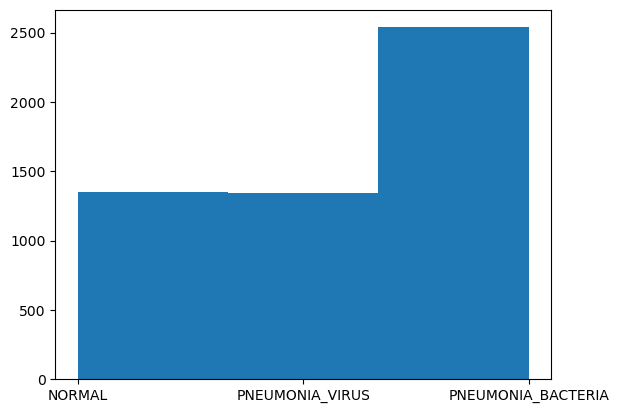

In [9]:
plt.hist(np_labels, len(set(np_labels)))
plt.show()

The division of observations into three classes does not solve the previous imbalance between 'normal' and 'pneumonia', and now shows a clear imbalance towards 'bacterial pneumonia', where approximately twice as many samples are observed as the rest of the possible classifications.

This imbalance can cause the training model to not learn all the features necessary to correctly differentiate between minority classes and resolve some samples to the majority class type due to a higher probability of correct predictions.

At this point we can choose three different paths:
- Complement the classes of the minority groups with another existing group. In many areas, as is the case with Health, it is possible that you are making use of all known data and no other complementary datasets are available.

- Extract observations from the dominant class. While extracting observations helps balance the classes, it could also be counterproductive, as it may result in missing observations with characteristics that could be representative and crucial for the model's representation. This technique is known as Undersampling.

- Balancing the dataset by replicating known data and applying synthetic changes, such as data augmentation. This technique is known as Oversampling.

- Balancing the dataset by assigning different weights to each class during model training. This approach gives more importance to the minority classes by adjusting the loss function, thereby improving the model's learning on those specific classes. This technique is known as Class Weighting.

To balance the data before starting to work on the models, the class weighting technique will be applied to give greater visibility to minority sets, and data augmentation will be used to apply random changes to the samples. This will synthetically generate new observations, thus leveling the observations in all classes present in the dataset.

## Summary of the images

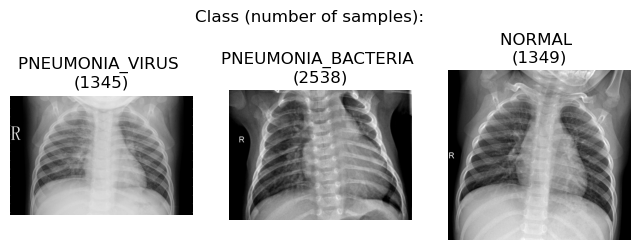

In [10]:
unique_labels = set(labels)
plt.figure(figsize=(8,3))
i=1
for label in unique_labels:
    temp_image = np_images[labels.index(label)]
    plt.subplot(1,len(unique_labels), i)
    plt.axis("off")
    plt.title("{0} \n({1})".format(label, labels.count(label)))
    i += 1
    plt.imshow(temp_image, cmap="gray")
plt.suptitle('Class (number of samples):')
plt.show()

The exploration of the dataset has allowed us to observe different issues that we need to address before passing the data to the training model.

- Images of very diverse sizes.
- Some images have excessively large dimensions, and considering the available hardware, it may be an unsustainable load.
- The images are in grayscale (pixel values between 0 and 255).
- Three possible classifications can be identified (normal, viral pneumonia, bacterial pneumonia).
- The distribution of images is not uniform. There are approximately twice as many samples of bacterial pneumonia compared to the other observations.
- The data is separated into training and test sets. We are interested in splitting the training set into 'training data' and 'validation data' to use the test data only for the final verification of models with data that has not been seen by the model before.


## Data preprocessing

For data preprocessing, the torchvision library is used, which is part of the PyTorch ecosystem, enabling the application of common solutions in the field of AI. Torchvision allows the use of a set of transformations that facilitate the creation and preparation of data sets to feed the input of the neural network.

As observed during the data exploration stage, one of the main issues is that all the images have different sizes. Therefore, the first transformation to be applied to the images is standardizing their size. Due to the considerable amount of space that the data can occupy, a size of 256x256 has been chosen to facilitate the loading supported by the hardware used and its limitations.

The images will also be transformed into Tensors, which is the way PyTorch operates with data, and they will be in the format (Color x Height x Width) within the range [0.0, 1.0]. Afterward, the data will be normalized with a mean value of 0.5 and a standard deviation of 0.5 to achieve a range of values between [-1, 1].

Finally, data augmentation techniques will be employed by applying rotation transformations of 25 degrees and taking random crops of 224x224 with a 50% randomness to generate a maximum number of synthetic images and expand the catalog of available observations for training.

### Data Augmentation

As observed in the initial dataset exploration, a key issue is the varying sizes of all images. Therefore, the initial transformation applied to standardize their size.

To address data storage considerations, a size of 256x256 has been selected for efficient loading on the utilized hardware, considering its limitations. Upon transforming the images into Tensor() format, they will be represented in the (CxHxW) format within the range (0.0, 1.0).

Data augmentation is employed by introducing rotation transformations of 25 degrees with a 50% randomness.

In [11]:
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((256, 256)),
                                transforms.RandomApply(torch.nn.ModuleList([
                                    transforms.RandomRotation(degrees=25),]), p=0.5),
                                transforms.ToTensor(),   # normalize data between [0, 1]
                                transforms.Normalize((0.5), (0.5))
                                ])

transform_test = transforms.Compose([transforms.Grayscale(num_output_channels=1),
                                transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))
                                ])

# The data sets (training and test) are extracted using the torchvision.datasets library.
train_dataset = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_data_dir, transform=transform_test)


# The training set is divided into training data and validation data.
train_set, validation_set = random_split(train_dataset, 
                                                 (int(len(train_dataset) * 0.8)+1,
                                                 int(len(train_dataset) * 0.2)))

# The dataset is wrapped in an iterable for better access to samples in the training set.
batch_size = 64
train_dataloader = DataLoader( train_set, batch_size=batch_size, shuffle=True )
valid_dataloader = DataLoader( validation_set, batch_size=batch_size, shuffle=True )
test_dataloader = DataLoader( test_dataset, batch_size=batch_size)

### Preview of the loaded data

Visualize some samples loaded from the training set.

In [12]:
def show_images (dataset):
    
    loader = torch.utils.data.DataLoader( dataset, batch_size=6, shuffle=True)
    batch = next(iter(loader))
    x_images, y_labels = batch
    
    grid = torchvision.utils.make_grid((x_images / 2 + 0.5), nrow=3)
    plt.figure(figsize=(11, 11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print('labels: ', y_labels)


labels:  tensor([1, 2, 1, 1, 1, 0])


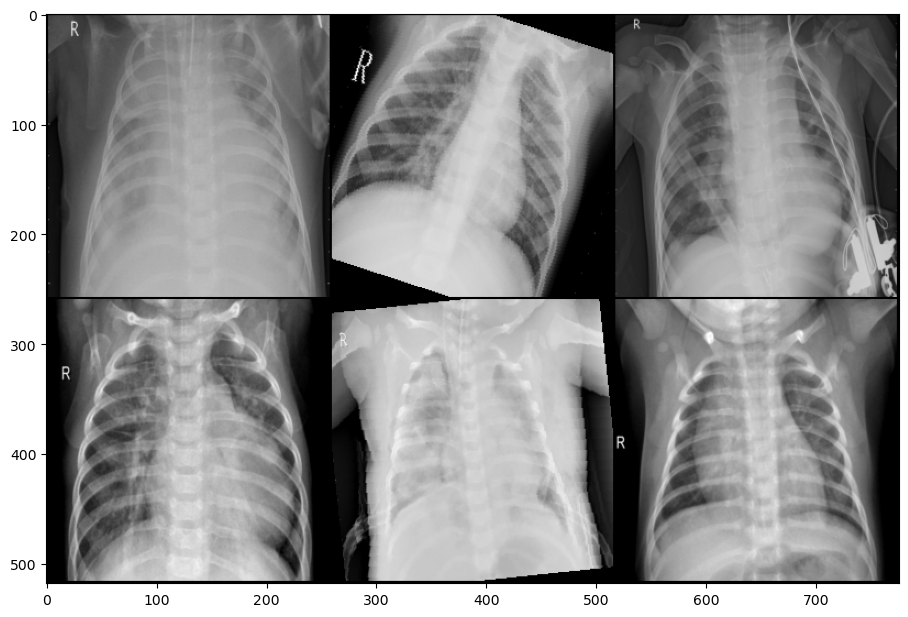

In [13]:
show_images(train_dataset)

Class weights, inversely proportional to frequency, will be applied to the loss function for each training model used.

In [16]:
set(labels)

{'NORMAL', 'PNEUMONIA_BACTERIA', 'PNEUMONIA_VIRUS'}

In [18]:
normal, bacteria, virus, total = count_labels(labels)

In [19]:
# class weights inversely proportional to frequency
class_weights = 1.0 / torch.tensor([normal, bacteria, virus], dtype=torch.float)

# Normalize weights to sum up to 1
class_weights = class_weights / class_weights.sum()

# Create the loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)